# Task 1: ideal mass-spring
Sam Greydanus

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate

solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

from Data_zong import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

In [2]:
# Hamiltonian function and dynamics (unchanged from your example)
def hamiltonian_fn(coords):
    q, p = np.split(coords, 2)
    H = p**2 / 2 + q**2 / 2  # spring hamiltonian (linear oscillator)
    return H

## Set some notebook constants

In [3]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

/Users/ZongyuWu/miniforge3/envs/KARHNN/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `mode`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


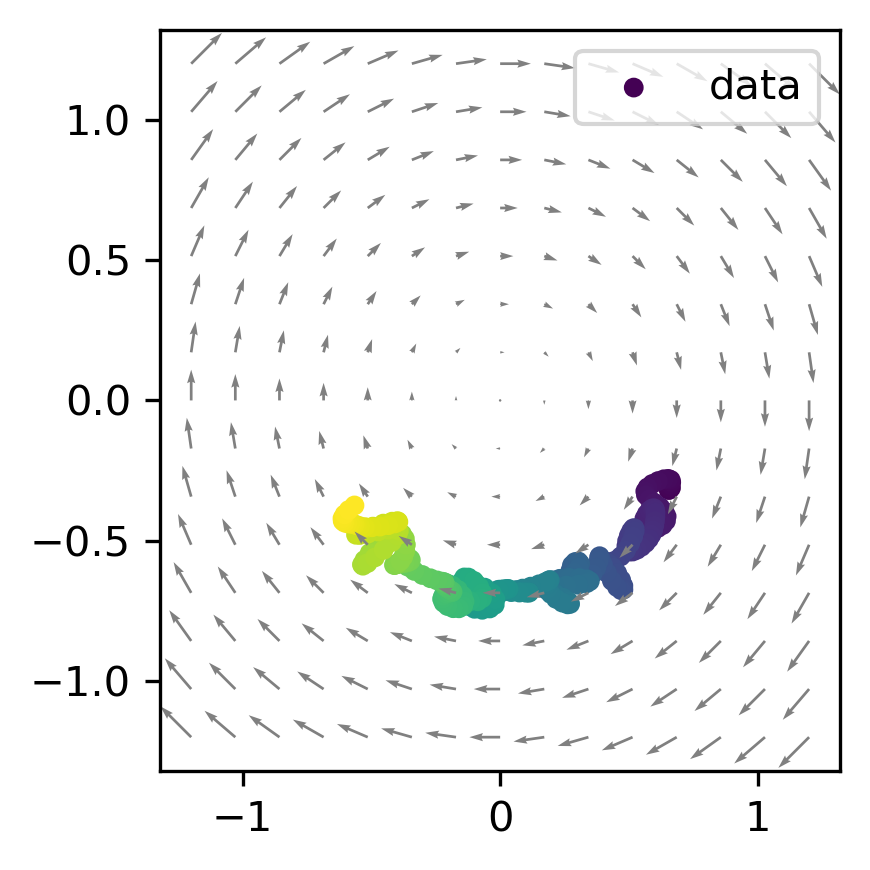

In [4]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
field = get_field(gridsize=15)
data = get_dataset(seed=0, mode=3)

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1,0]), noise_std=0.1)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
# plt.xlabel("$x$", fontsize=14)
# plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
# plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

## Construct models

In [5]:
def get_model(args, model_name):
    # output_dim = args.input_dim if baseline else 2
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=False)
    
    # model_name = 'baseline' if baseline else 'hnn'
    path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [6]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [8]:
denoise_model = get_model(args, model_name='denoise')
denoise_model.eval()
noise_model = get_model(args, model_name='noise')
noise_model.eval()

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset(seed=0, mode=3)
denoise_field = get_vector_field(denoise_model, gridsize=args.gridsize)
noise_field = get_vector_field(noise_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
denoise_ivp = integrate_model(denoise_model, t_span, y0, **kwargs)
noise_ivp = integrate_model(noise_model, t_span, y0, **kwargs)


/var/folders/yf/ztggt9hs5mvc5xgtr219fdp00000gp/T/ipykernel_95326/2454232304.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


## Plot results

/Users/ZongyuWu/miniforge3/envs/KARHNN/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `mode`, `keep_frequencies`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


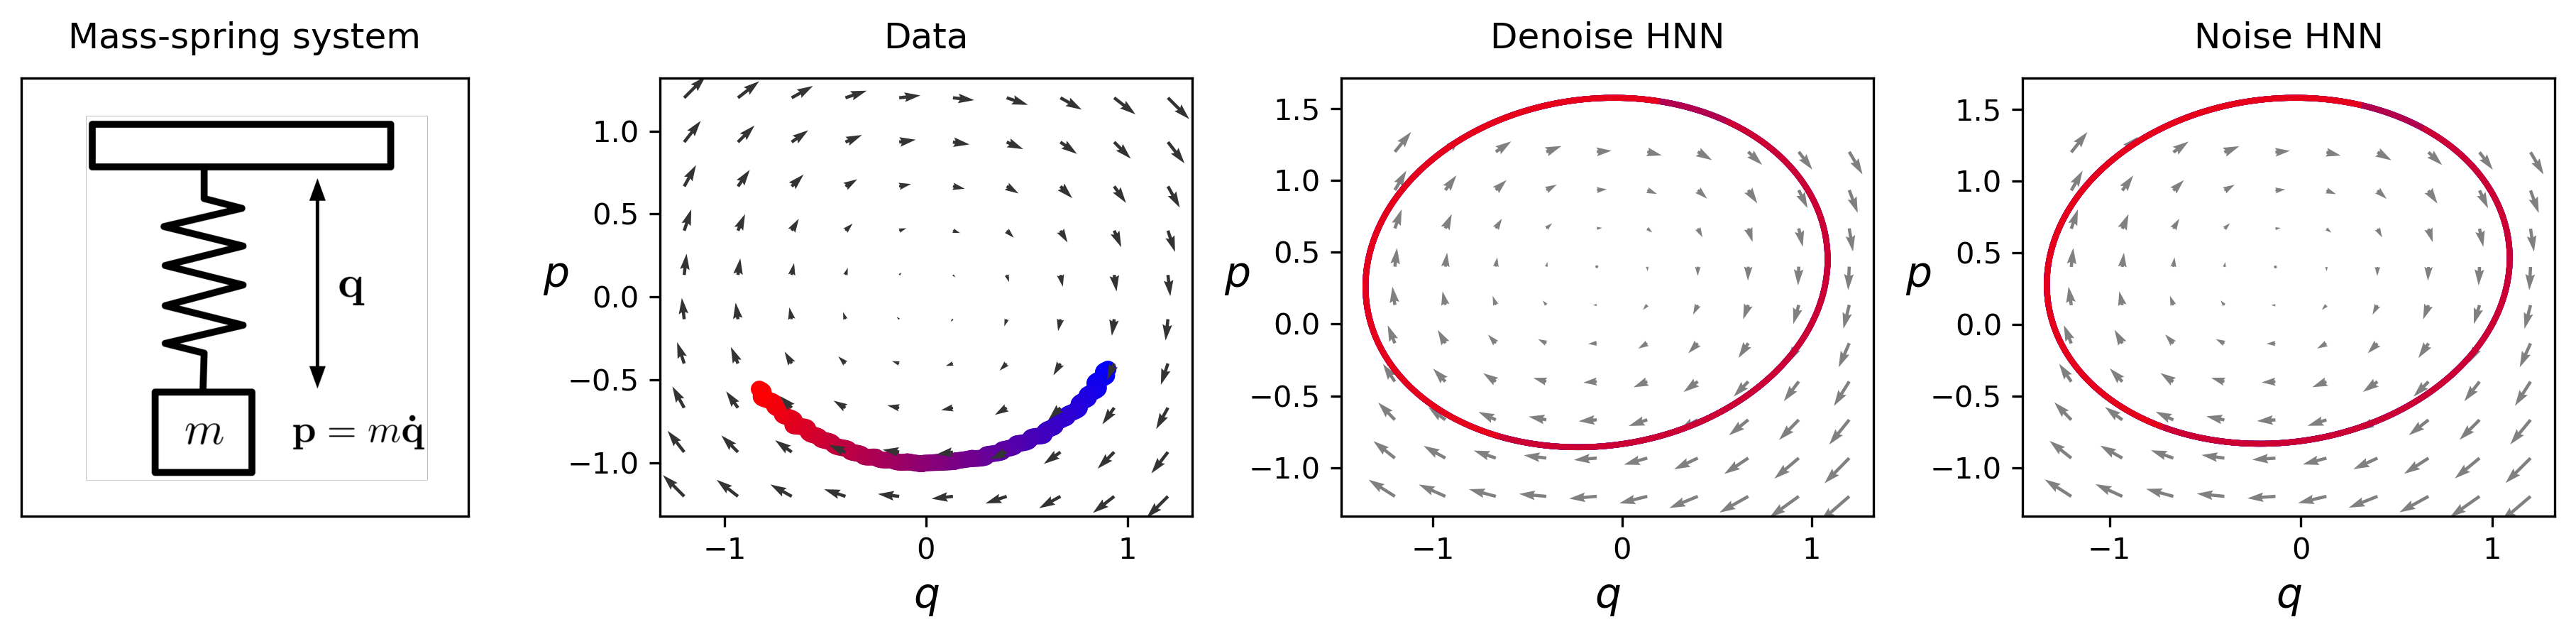

In [9]:
###### PLOT ######
fig = plt.figure(figsize=(12.4, 3.1), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
plt.imshow(schema)
plt.title("Mass-spring system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,0]), mode=3, noise_std=1e-2, keep_frequencies=10)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot denoiseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], denoise_field[:,0], denoise_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(denoise_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Denoise HNN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], noise_field[:,0], noise_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(noise_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Noise HNN", pad=10)

plt.tight_layout()
plt.show()
fig.savefig("{}/spring{}.{}".format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [10]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    denoise_path = integrate_model(denoise_model, t_span, x0, **kwargs)
    denoise_x = denoise_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    noise_path = integrate_model(noise_model, t_span, x0, **kwargs)
    noise_x = noise_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, denoise_x, noise_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

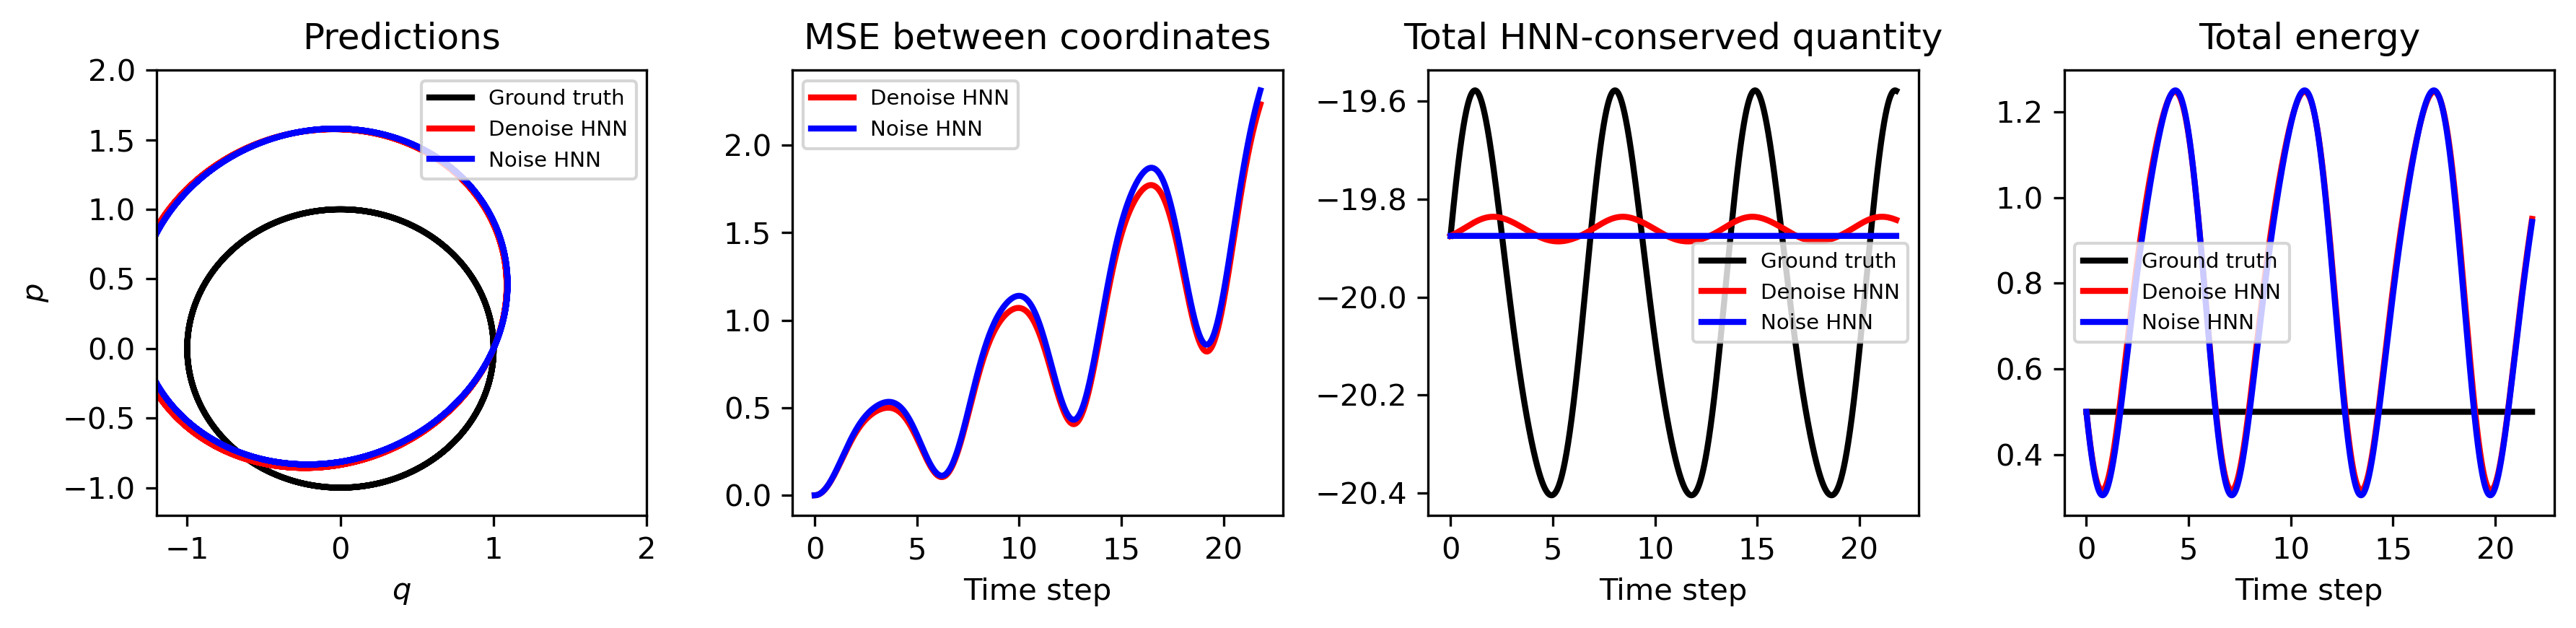

In [11]:
x0 = np.asarray([1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, denoise_x, noise_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(denoise_x[:,0], denoise_x[:,1], 'r-', label='Denoise HNN', linewidth=2)
plt.plot(noise_x[:, 0], noise_x[:, 1], "b-", label="Noise HNN", linewidth=2)
plt.xlim(-1.2, 2)
plt.ylim(-1.2, 2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-denoise_x)**2).mean(-1), 'r-', label='Denoise HNN', linewidth=2)
plt.plot(
    t_eval, ((true_x - noise_x) ** 2).mean(-1), "b-", label="Noise HNN", linewidth=2
)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = noise_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
denoise_hq = noise_model(torch.Tensor(denoise_x))[1].detach().numpy().squeeze()
noise_hq = noise_model(torch.Tensor(noise_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, "k-", label="Ground truth", linewidth=2)
plt.plot(t_eval, denoise_hq, 'r-', label='Denoise HNN', linewidth=2)
plt.plot(t_eval, noise_hq, "b-", label="Noise HNN", linewidth=2)
plt.legend(fontsize=7)


plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
denoise_e = np.stack([hamiltonian_fn(c) for c in denoise_x])
noise_e = np.stack([hamiltonian_fn(c) for c in noise_x])
plt.plot(t_eval, true_e, "k-", label="Ground truth", linewidth=2)
plt.plot(t_eval, denoise_e, 'r-', label='Denoise HNN', linewidth=2)
plt.plot(t_eval, noise_e, "b-", label="Noise HNN", linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [12]:
splits = 5
samples = 3
losses = {'denoise_energy' : [], 'noise_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, denoise_x, noise_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    losses['denoise_energy'] += [ energy_loss(true_x, denoise_x) ]
    losses["noise_energy"] += [energy_loss(true_x, noise_x)]
    print("{:.2f}% done".format(100 * float(i) / (splits * samples)), end="\r")

In [13]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print(
    "\nDenoise HNN energy MSE: {:.4e} +/- {:.2e}\nNoise HNN energy MSE: {:.4e} +/- {:.2e}".format(
        np.mean(losses["denoise_energy"]),
        bootstrap_conf(losses["denoise_energy"], splits),
        np.mean(losses["noise_energy"]),
        bootstrap_conf(losses["noise_energy"], splits),
    )
)


Denoise HNN energy MSE: 7.5080e-01 +/- 1.30e-01
Noise HNN energy MSE: 7.8897e-01 +/- 1.31e-01


/Users/ZongyuWu/miniforge3/envs/KARHNN/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `mode`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


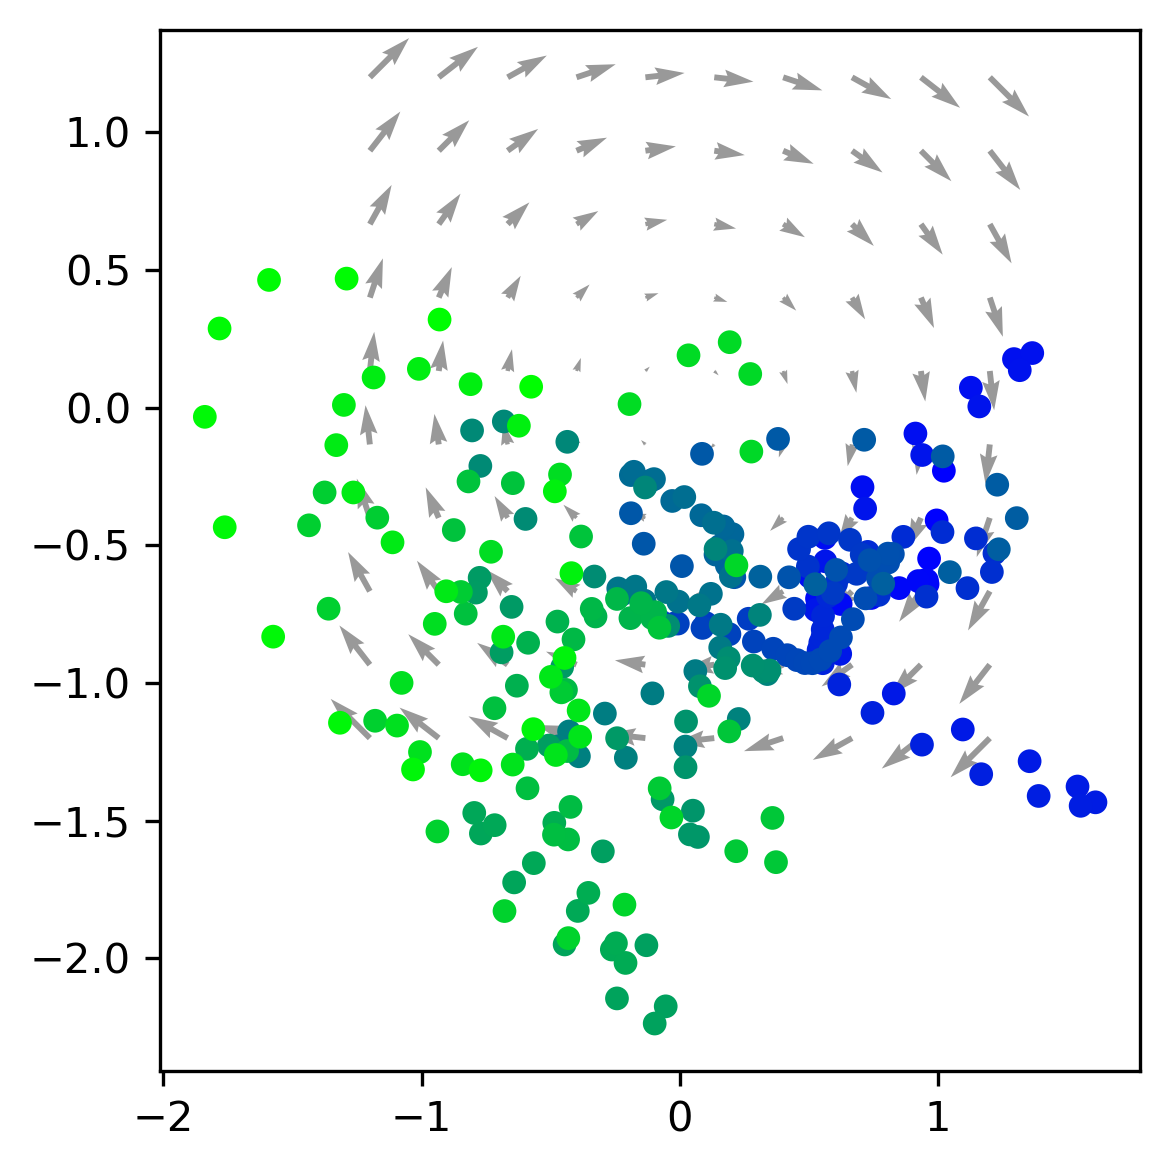

In [14]:
###### PLOT ######
fig = plt.figure(figsize=(4, 4), facecolor='white', dpi=DPI)


# plot dynamics
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,0]), mode=3, noise_std=1.0)
N = len(x)
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.6,.6,.6))  
point_colors = [(0,i/N, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

# plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$p$", rotation=0, fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig("{}/spring_data.png".format(args.fig_dir, RK4, FORMAT))